In [2]:
#Importing Required modules
import os
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import rdFMCS
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
from rdkit.Chem import rdRGroupDecomposition
from rdkit.Chem import rdmolops
from rdkit.Chem import RDConfig
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import rdMolHash
from rdkit.Chem import rdMolDescriptors
from pathlib import Path
from collections import defaultdict
from itertools import product
import igraph
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import re
IPythonConsole.ipython_useSVG = True

In [5]:
# Creating a function to generate graph of mol
def gengraph(mols,fpgen , threshold=0.7):
    fps = [fpgen.GetFingerprint(m) for m in mols]
    num_v = len(mols)
    graph = igraph.Graph()
    graph.add_vertices(num_v)
    for i in range(num_v):
        for j in range(i):
            if DataStructs.TanimotoSimilarity(fps[i], fps[j]) >= threshold:
                graph.add_edge(i, j)
    return graph

In [6]:
# A function that joins 2 molecules together

def makebond(target, chain):
    newmol = Chem.RWMol(rdmolops.CombineMols(target, chain))
    atoms = newmol.GetAtoms()
    mapper = defaultdict(list)
    for idx, atm in enumerate(atoms):
        atom_map_num = atm.GetAtomMapNum()
        mapper[atom_map_num].append(idx)
    for idx, a_list in mapper.items():
        if len(a_list) == 2:
            atm1, atm2 = a_list
            rm_atoms = [newmol.GetAtomWithIdx(atm1),newmol.GetAtomWithIdx(atm2)]
            nbr1 = [x.GetOtherAtom(newmol.GetAtomWithIdx(atm1)) for x in newmol.GetAtomWithIdx(atm1).GetBonds()][0]
            nbr1.SetAtomMapNum(idx)
            nbr2 = [x.GetOtherAtom(newmol.GetAtomWithIdx(atm2)) for x in newmol.GetAtomWithIdx(atm2).GetBonds()][0]
            nbr2.SetAtomMapNum(idx)
    newmol.AddBond(nbr1.GetIdx(), nbr2.GetIdx(), order=Chem.rdchem.BondType.SINGLE)
    nbr1.SetAtomMapNum(0)
    nbr2.SetAtomMapNum(0)
    newmol.RemoveAtom(rm_atoms[0].GetIdx())
    newmol.RemoveAtom(rm_atoms[1].GetIdx())
    newmol = newmol.GetMol()
    return newmol

In [7]:
#Creating a function that generates multiple molcules from a single core

def enumeratemol(core,rg, maxmol=10000):
    dataset = rg.GetRGroupsAsColumns()
    labels = list(dataset.keys())
    pat = re.compile("R\d+")
    labels = [label for label in labels if pat.match(label)]
    rgs = np.asarray([dataset[label] for label in labels])
    i, j = rgs.shape
    combs = [k for k in product(range(j), repeat=i)]
    res = []
    for i in combs:
        mol = core
        for idx,j in enumerate(i):
            mol = makebond(mol, rgs[idx][j])
        AllChem.Compute2DCoords(mol)
        mol = Chem.RemoveHs(mol)
        res.append(mol)
    return res

In [8]:
# using fingerprint gen function

fpgen = rdFingerprintGenerator.GetMorganGenerator(2)

In [9]:
#

mols = [m for m in Chem.SDMolSupplier('core.sdf')]
for mol in mols:
    AllChem.Compute2DCoords(mol)
fps = [fpgen.GetFingerprint(m) for m in mols]


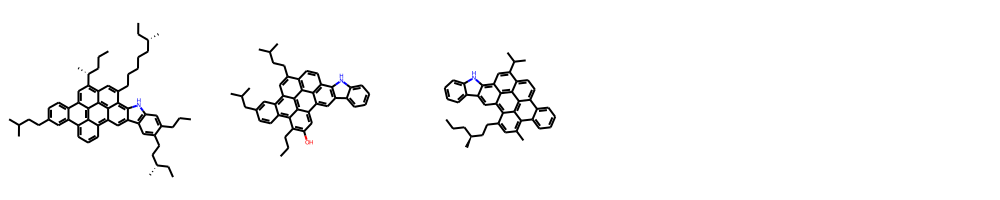

In [10]:
Draw.MolsToGridImage(mols, molsPerRow=5)

In [11]:
graph = gengraph(mols, fpgen, 0.4)
blks=graph.blocks()
simmols_idx = sorted(list(blks), key=lambda x: len(x), reverse=True)
simmols_idx

[[0, 1, 2]]

In [12]:
simmols = [mols[i] for i in simmols_idx[0]]
scaff = [MurckoScaffold.GetScaffoldForMol(m) for m in simmols]
scaff

In [13]:
mcs1 = rdFMCS.FindMCS(scaff, threshold=0.7)
mcs2 = rdFMCS.FindMCS(scaff, threshold=0.7, 
                      completeRingsOnly=True,
                      matchValences=True,
                      bondCompare=rdFMCS.BondCompare.CompareOrderExact,
                      atomCompare=rdFMCS.AtomCompare.CompareElements,
                      )
mcs3 = rdFMCS.FindMCS(scaff, threshold=0.7,
                      ringMatchesRingOnly=True,
                      completeRingsOnly=True,
                      atomCompare=rdFMCS.AtomCompare.CompareAny)

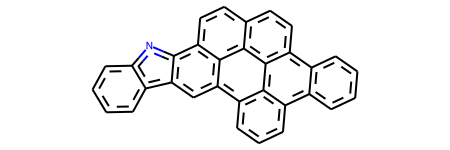

In [14]:
Chem.MolFromSmarts(mcs1.smartsString)

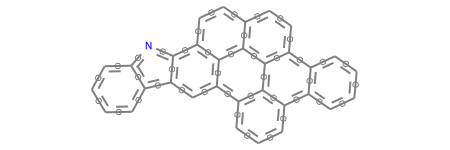

In [15]:
Chem.MolFromSmarts(mcs2.smartsString)

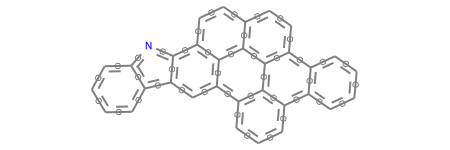

In [16]:
Chem.MolFromSmarts(mcs3.smartsString)

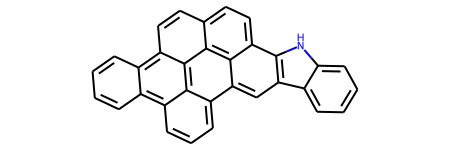

In [17]:
mols_has_core = []
core = Chem.MolFromSmarts(mcs2.smartsString)
for mol in mols:
    if mol.HasSubstructMatch(core):
        AllChem.Compute2DCoords(mol)
        mols_has_core.append(mol)
def getMCSSmiles(mol, mcs):
    mcsp = Chem.MolFromSmarts(mcs.smartsString)
    match = mol.GetSubstructMatch(mcsp)
    smi = Chem.MolFragmentToSmiles(mol, atomsToUse=match)
    return smi
mcs_smi = getMCSSmiles(mols_has_core[0], mcs1)
core = Chem.MolFromSmiles(mcs_smi)
core

only if these 3 has same core, this program will run

In [18]:
rgp = rdRGroupDecomposition.RGroupDecompositionParameters()
rgp.removeHydrogensPostMatch = True
rgp.alignment =True
rgp.removeAllHydrogenRGroups=True
rg = rdRGroupDecomposition.RGroupDecomposition(core, rgp)
for mol in mols_has_core:
    rg.Add(mol)
rg

In [19]:
rg.Process()

True

In [20]:
frame = pd.DataFrame(rg.GetRGroupsAsColumns())
frame["Smiles"] = [Chem.MolToSmiles(mol) for mol in mols_has_core]
PandasTools.AddMoleculeColumnToFrame(frame)

,ROMol,Smiles,Core,R1,R2
0,,CCCc1cc2[nH]c3c(cc4c5cccc6c7cc(CCC(C)C)ccc7c7c...,,,
1,,CCCc1c(O)cc2c3cc4c5ccccc5[nH]c4c4ccc5c(CCC(C)C...,,,
2,,CCC[C@H](C)CCc1cc(C)c2c3ccccc3c3ccc4c(C(C)C)cc...,,,

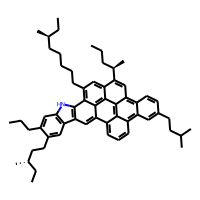
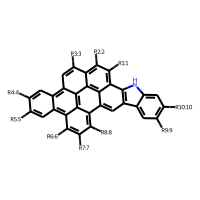
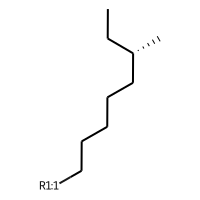
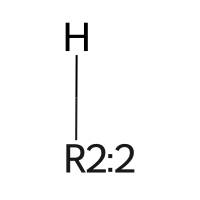
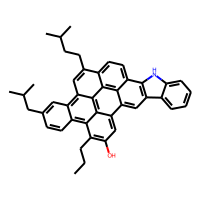
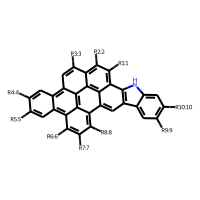
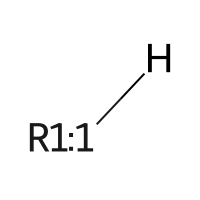
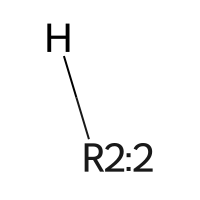
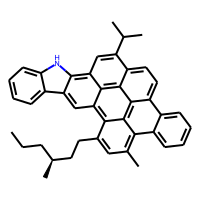
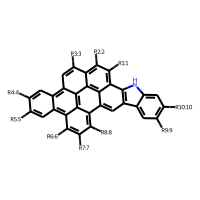
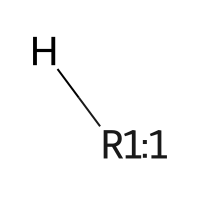
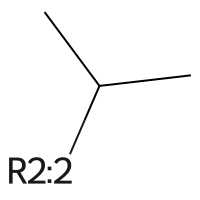

In [21]:
frame = frame[["ROMol", "Smiles", "Core", "R1", "R2"]]
frame['Core']=frame['Core'].apply(Chem.RemoveHs)
frame.head()

In [22]:
dataset = rg.GetRGroupsAsColumns()
core =  Chem.RemoveHs(dataset["Core"][0])

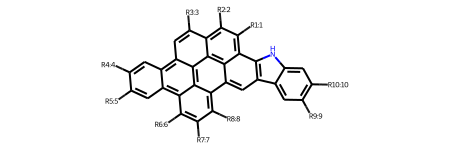

In [23]:
core

In [24]:
res = enumeratemol(core,rg)

C:\Users\Kakashi\anaconda3\envs\my-rdkit-env\lib\site-packages\rdkit\Chem\Draw\IPythonConsole.py:252: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


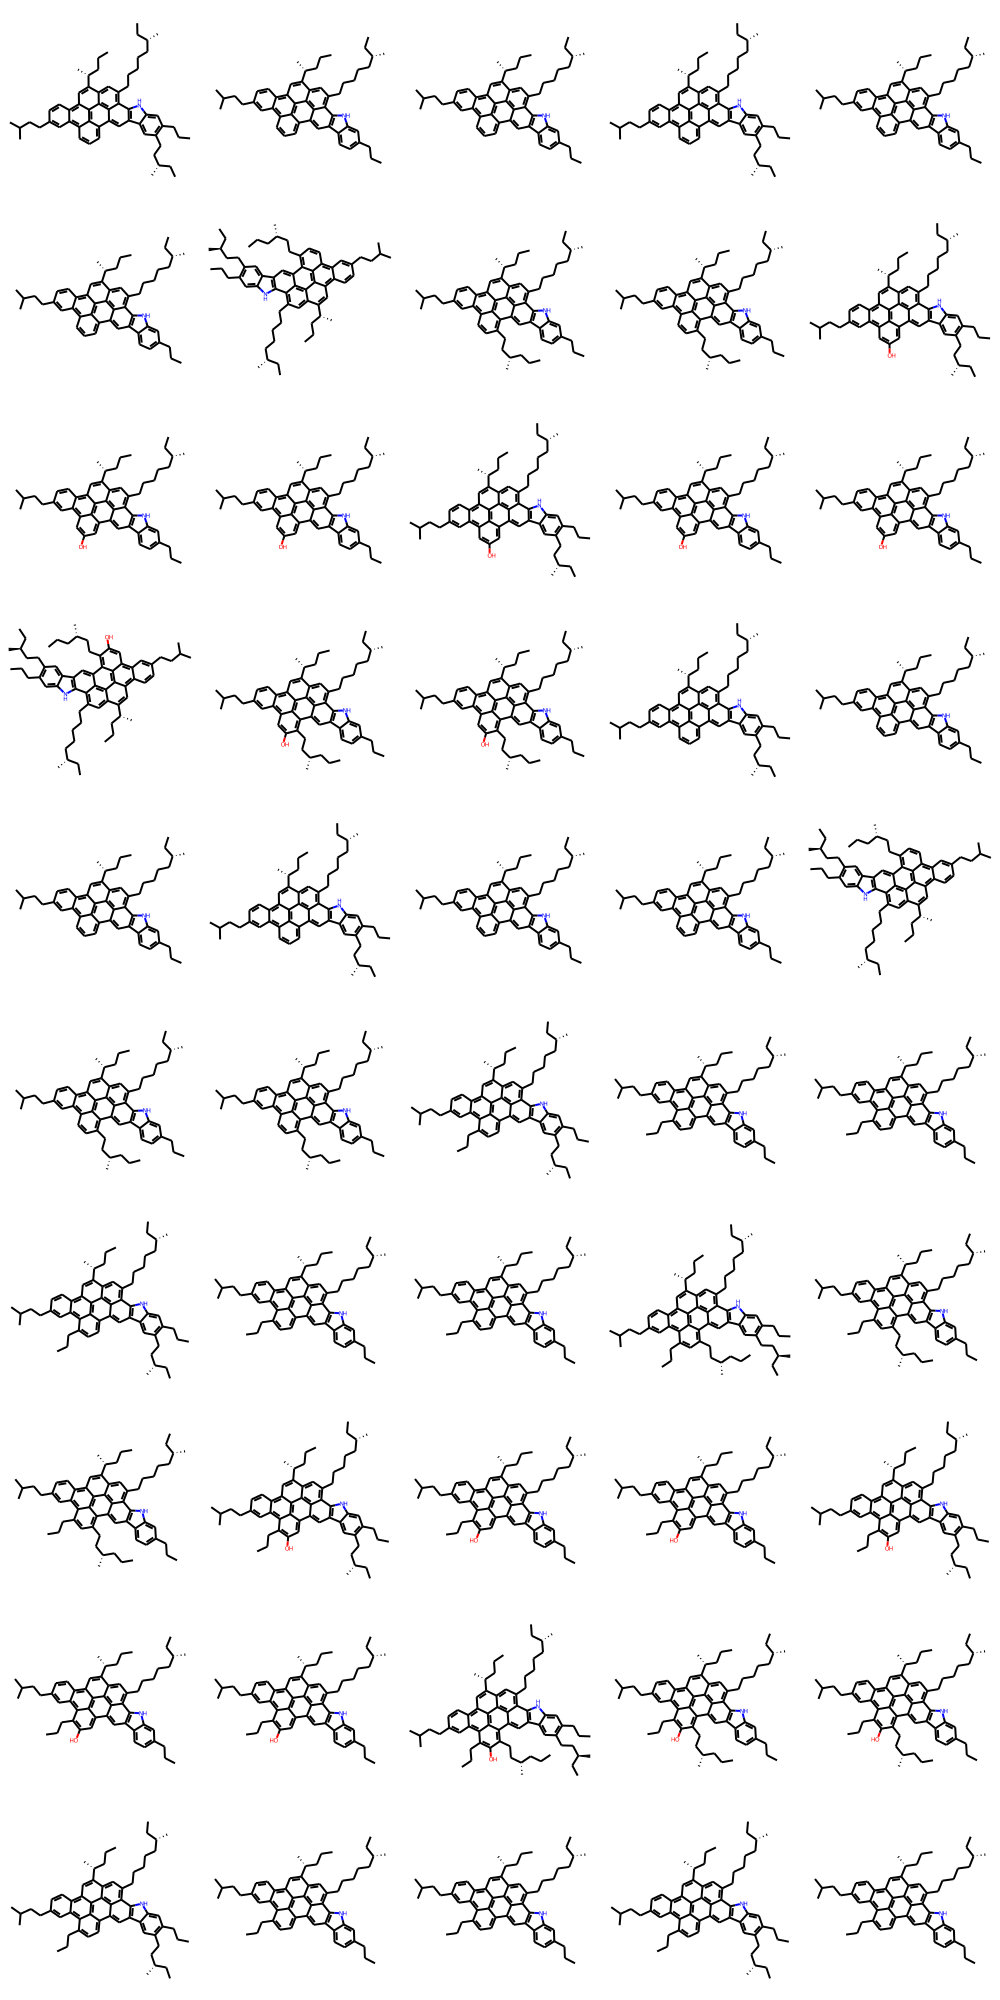

In [25]:
Draw.MolsToGridImage(res[:200],molsPerRow=5)

In [26]:
print(len(res),'molecules generated')

59049 molecules generated


In [27]:
print(res)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [28]:
listsmiles=[]
for m in res:
    listsmiles.append(Chem.MolToSmiles(m))
len(listsmiles)

59049

In [29]:
print(listsmiles)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [54]:
unique=set(listsmiles)
unique=list(unique)

In [57]:
def getsmolformula(x):
    molhashf = rdMolHash.HashFunction.names
    for i, j in molhashf.items():
        if i == 'MolFormula':
            form=rdMolHash.MolHash(x, j)
    return form

In [58]:
formula_unique=[]
for i in unique:
    formula_unique.append(getsmolformula(Chem.MolFromSmiles(i)))
formula_unique

['C57H67NO',
 'C44H41NO',
 'C47H47NO',
 'C49H51N',
 'C66H85N',
 'C49H51N',
 'C53H59NO',
 'C46H45NO',
 'C62H77NO',
 'C54H61N',
 'C60H73NO',
 'C53H59N',
 'C53H59N',
 'C38H29N',
 'C66H85N',
 'C32H17NO',
 'C68H89NO',
 'C55H63NO',
 'C59H71N',
 'C49H51N',
 'C53H59N',
 'C48H49NO',
 'C62H77N',
 'C65H83NO',
 'C44H41NO',
 'C59H71NO',
 'C56H65NO',
 'C56H65NO',
 'C56H65N',
 'C46H45N',
 'C40H33NO',
 'C64H81N',
 'C61H75NO',
 'C53H59NO',
 'C56H65N',
 'C47H47N',
 'C65H83NO',
 'C48H49N',
 'C52H57NO',
 'C59H71N',
 'C70H93N',
 'C53H59NO',
 'C56H65N',
 'C55H63N',
 'C60H73NO',
 'C61H75NO',
 'C56H65NO',
 'C68H89NO',
 'C47H47N',
 'C43H39N',
 'C64H81N',
 'C40H33N',
 'C51H55N',
 'C50H53N',
 'C54H61NO',
 'C69H91N',
 'C44H41NO',
 'C53H59NO',
 'C47H47N',
 'C63H79NO',
 'C61H75NO',
 'C54H61NO',
 'C43H39NO',
 'C63H79N',
 'C40H33NO',
 'C61H75NO',
 'C41H35N',
 'C53H59NO',
 'C68H89NO',
 'C49H51NO',
 'C60H73N',
 'C50H53NO',
 'C60H73N',
 'C63H79N',
 'C56H65N',
 'C57H67N',
 'C60H73NO',
 'C58H69NO',
 'C59H71NO',
 'C63H79NO

2304 unique molecules generated


C:\Users\Kakashi\anaconda3\envs\my-rdkit-env\lib\site-packages\rdkit\Chem\Draw\IPythonConsole.py:252: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


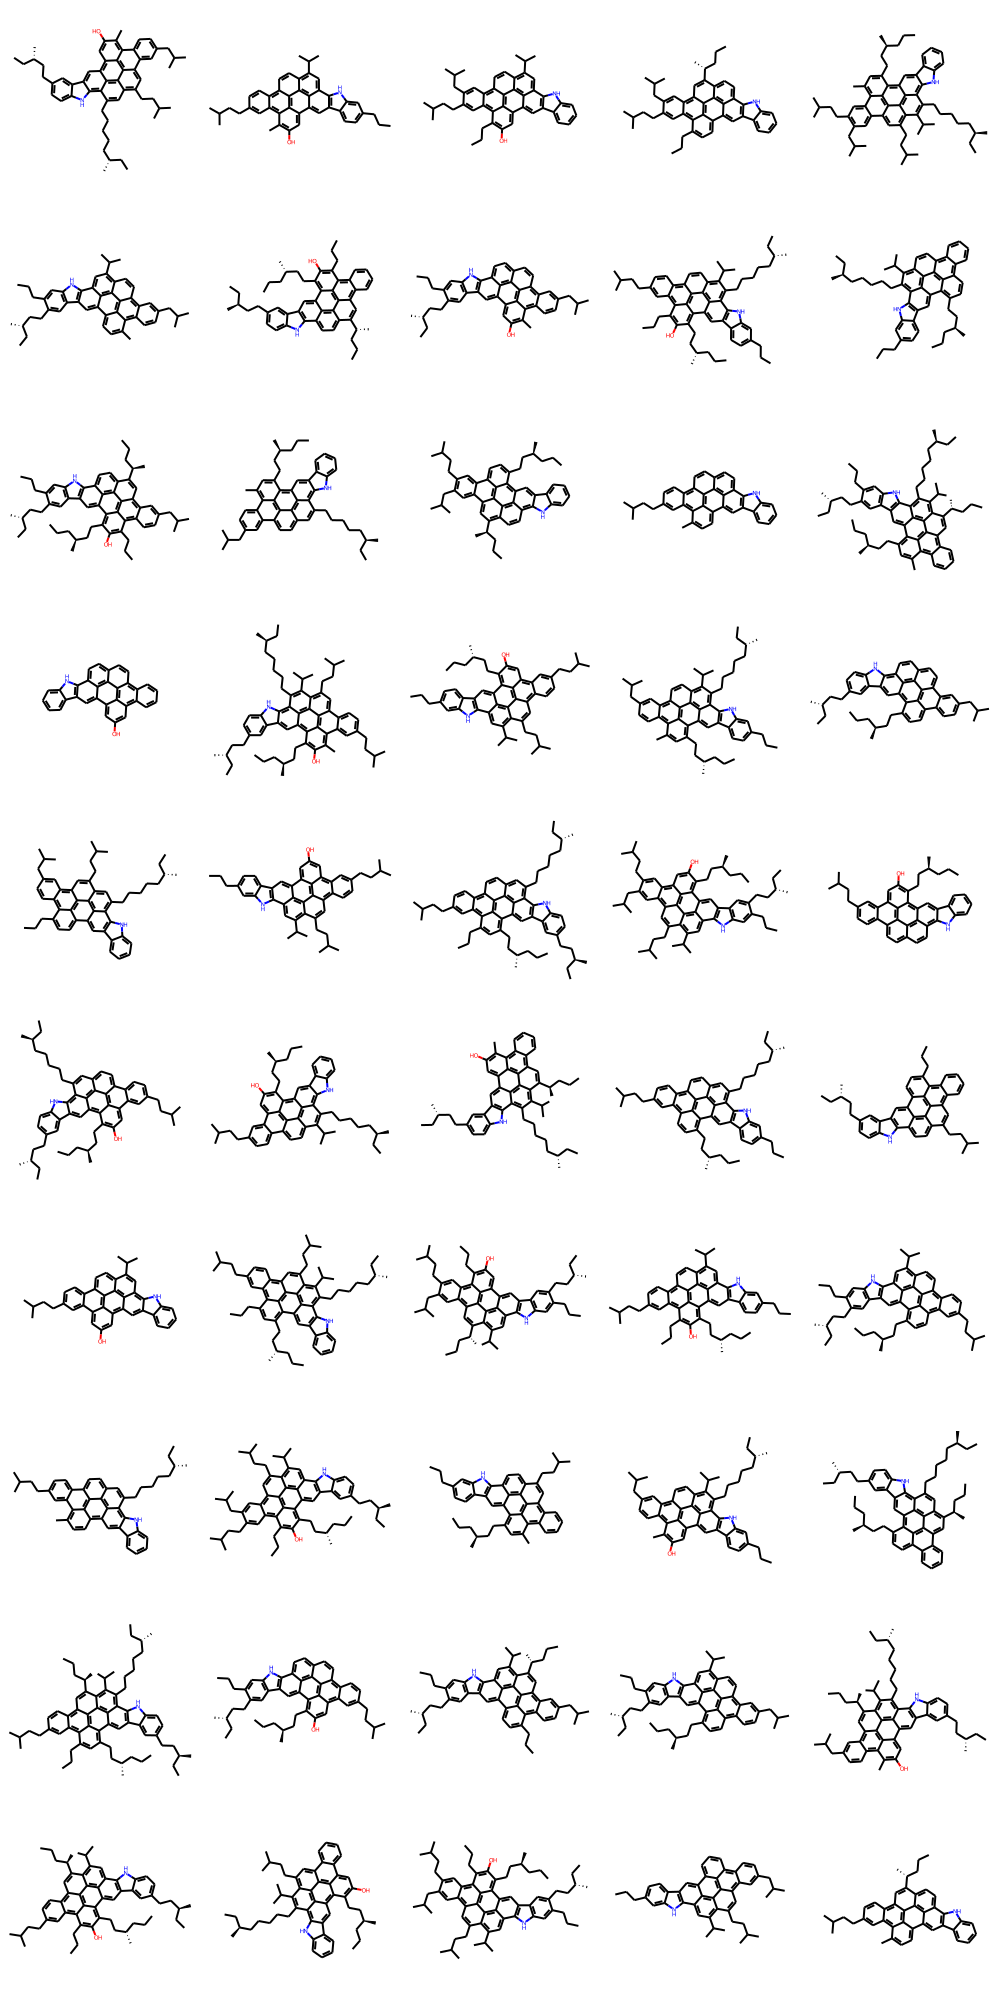

In [59]:
uniquemols=[]
for i in unique:
    uniquemols.append(Chem.MolFromSmiles(i))
print(len(uniquemols), "unique molecules generated")
Draw.MolsToGridImage(uniquemols[:100], molsPerRow=5)

In [60]:
pilform=[]
for i in uniquemols:
    pilform.append(Draw.MolToImage(i))
uniquemolcore1 = pd.DataFrame(pilform[:2305],columns=['Structure'])

In [61]:
uniquemolcore1.insert(0,'Smiles',unique,True)
uniquemolcore1.insert(1,'Formula',formula_unique,True)

In [62]:
def rotb(x):
    
    rot_bonds=[]
    for i in x:
        rot_bonds.append(Chem.rdMolDescriptors.CalcNumRotatableBonds(i))
    return rot_bonds

In [63]:
def het_atom(x):
    hetero_atoms=[]
    for i in x:
        hetero_atoms.append(Chem.rdMolDescriptors.CalcNumHeteroatoms(i))
    return hetero_atoms

In [64]:
def no_of_atoms(x):
    no_ofatoms=[]
    for i in x:
        no_ofatoms.append(Chem.rdMolDescriptors.CalcNumAtoms(i))
    return no_ofatoms

In [65]:
def mol_weight(x):
    mol_wei=[]
    for i in x:
        mol_wei.append(Chem.rdMolDescriptors.CalcExactMolWt(i))
    return mol_wei

In [66]:
# Creating multiple features 

rotun = rotb(uniquemols)
hetun = het_atom(uniquemols)
noatomun = no_of_atoms(uniquemols)
molwun = mol_weight(uniquemols)

In [67]:
class get_atom_num:
    
    def __init__(self,f):
        self.f = f
        
    def carbons(self):
        number_of_carbons=[]
        for i in self.f:
            first = re.split('[a-z]+',i, flags=re.IGNORECASE)
            toaddc = int(first[1])
            number_of_carbons.append(toaddc)
        return number_of_carbons

    def nitrogens(self):
        number_of_nitrogens=[]
        for i in self.f:
            third = re.split('[a-z]+', i, flags=re.IGNORECASE)         
            if third[3] == '':
                number_of_nitrogens.append('1') 
            else:
                toaddn = int(third[3])
                number_of_nitrogens.append(toaddn)
        return number_of_nitrogens
    
    def hydro(self):
        noh=[]
        for i in self.f:
            second = re.split('[a-z]+', i, flags=re.IGNORECASE)
            toaddh = int(second[2])
            noh.append(toaddh)
        return noh

    def oxygens(self):
        number_of_oxygens=[]
        for i in self.f:
            fourth = re.split('[a-z]+', i, flags=re.IGNORECASE)
            if len(fourth)<=4 or fourth[4]=='':
                number_of_oxygens.append('0')
            else:
                toaddo = int(fourth[4])
                number_of_oxygens.append(toaddo)
        return number_of_oxygens


In [68]:
uniq_atom_num = get_atom_num(formula_unique)
number_of_carbons_un = uniq_atom_num.carbons()
number_of_nitrogens_un = uniq_atom_num.nitrogens() 
number_of_hydrogens_un = uniq_atom_num.hydro() 
number_of_oxygens_un = uniq_atom_num.oxygens()


In [69]:
# adding multiple features to the dataframe
uniquemolcore1.insert(1,'No of atoms',noatomun,True)
uniquemolcore1.insert(2,'hetero atoms',hetun,True)
uniquemolcore1.insert(3,'Number of carbons',number_of_carbons_un,True)
uniquemolcore1.insert(4,'Number of Hydrogens',number_of_hydrogens_un,True)
uniquemolcore1.insert(5,'Number of Oxygens',number_of_oxygens_un,True)
uniquemolcore1.insert(6,'Number of Nitrogens',number_of_nitrogens_un,True)
uniquemolcore1.insert(7,'Mol Weight',molwun,True)
uniquemolcore1.insert(8,'rotatable bonds',rotun,True)



In [70]:
uniquemolcore1

,Smiles,No of atoms,hetero atoms,Number of carbons,Number of Hydrogens,Number of Oxygens,Number of Nitrogens,Mol Weight,rotatable bonds,Formula,Structure
0,CC[C@H](C)CCCCCc1cc2c(CCC(C)C)cc3c4cc(CC(C)C)c...,126,2,57,67,0,1,781.522266,16,C57H67NO,<PIL.PngImagePlugin.PngImageFile image mode=RG...
1,CCCc1ccc2c(c1)[nH]c1c2cc2c3cc(O)c(C)c4c5cc(CCC...,87,2,44,41,0,1,599.318815,6,C44H41NO,<PIL.PngImagePlugin.PngImageFile image mode=RG...
2,CCCc1c(O)cc2c3cc4c5ccccc5[nH]c4c4cc(C(C)C)c5cc...,96,2,47,47,0,1,641.365765,8,C47H47NO,<PIL.PngImagePlugin.PngImageFile image mode=RG...
3,CCCc1ccc2c3cc4c5ccccc5[nH]c4c4ccc5c([C@H](C)CC...,101,1,49,51,0,1,653.402151,10,C49H51N,<PIL.PngImagePlugin.PngImageFile image mode=RG...
4,CCC[C@H](C)CCc1cc(C)c2c3cc(CCC(C)C)c(CC(C)C)cc...,152,1,66,85,0,1,891.668202,21,C66H85N,<PIL.PngImagePlugin.PngImageFile image mode=RG...
...,...,...,...,...,...,...,...,...,...,...,...
2299,CCC[C@H](C)CCc1c(O)c(C)c2c3ccc(CC(C)C)cc3c3ccc...,114,2,53,59,0,1,725.459666,12,C53H59NO,<PIL.PngImagePlugin.PngImageFile image mode=RG...
2300,CCC[C@@H](C)c1cc2c3ccc(CCC(C)C)cc3c3cc(O)cc4c5...,126,2,57,67,0,1,781.522266,17,C57H67NO,<PIL.PngImagePlugin.PngImageFile image mode=RG...
2301,CCCc1cc2[nH]c3c(cc4c5ccc(C)c6c7ccc(CC(C)C)cc7c...,143,1,63,79,0,1,849.621252,19,C63H79N,<PIL.PngImagePlugin.PngImageFile image mode=RG...
2302,CCCc1c(O)c(CC[C@@H](C)CCC)c2c3cc4c5cc(CC[C@@H]...,168,2,71,95,0,1,977.741367,26,C71H95NO,<PIL.PngImagePlugin.PngImageFile image mode=RG...


In [75]:
uniquemolcore1.to_csv('uniqcore1.csv')

In [72]:
import os, sys
from PIL import Image
filepath = Path('\shape')
for i in range(len(pilform)):
    f = 'mol'+ str(i)
    outfile = f + ".jpg"
    pilform[i].save(outfile)

In [74]:

# Insert Multiple Images into Excel Cells with Python
# PULL IN FILENAMES AND TITLES INSTEAD OF ADDING MANUALLY

import xlsxwriter
import glob
import os
from natsort import natsorted

# create a new Excel file and add a worksheet
workbook = xlsxwriter.Workbook('uniq_core_1_with_images.xlsx')
worksheet = workbook.add_worksheet()

# resize cells
# worksheet.set_column('B1:B5', 7)
worksheet.set_column(first_col=0, last_col=0, width=10)
worksheet.set_column(first_col=1, last_col=1, width=7)
worksheet.set_default_row(45)

# images list
images = []
for filename in natsorted(glob.glob('Shape/*.jpg')):
    images.append(filename)

# insert images
image_row = 0
image_col = 1
for image in images:
    worksheet.insert_image(image_row, 
                           image_col, 
                           image, 
                           {'x_scale':0.2, 'y_scale': 0.2, 
                            'x_offset': 0, 'y_offset': 0,}) 
    image_row += 1
    
# adding serial numbers
sn_row=0
sn_col=0
sn=1
while sn <= len(unique):
    worksheet.write(sn_row,sn_col,sn)
    sn_row+=1
    sn+=1
# add smiles
smile_row=0
smile_col=2
for sm in unique:
    worksheet.write(smile_row,smile_col,sm)
    smile_row +=1
    
# add formula
formula_row=0
formula_col=3
for fm in formula_unique:
    worksheet.write(formula_row,formula_col,fm)
    formula_row +=1

workbook.close()